# Applying a location model to discretionary activities

This notebook applies a time-prism approach for choosing the location of non-mandatory activities. With this approach, agents try to sensibly combine the location of their discretionary activities around the locations of “anchor points” (defined as the locations of mandatory activities – home, employment, education).

The `pam.planner.choice_location.DiscretionaryTrips` class allows the user to apply the time-space prism approach on a PAM plan, given accessibility and attraction data.

The typical workflow goes as follows:

``` python
model = DiscretionaryTrips(population, od) # initialize the model and point to the data objects 
model.update_plan() # apply the model and update the location of each non-mandatory activity in the plan
```

In [1]:
import logging
import random
from copy import deepcopy

import numpy as np
import pandas as pd
from prettytable import PrettyTable
from shapely.geometry import Point

from pam.activity import Activity, Leg, Plan
from pam.location import Location
from pam.planner.choice_location import DiscretionaryTripOD, DiscretionaryTrips
from pam.planner.od import ODFactory, ODMatrix
from pam.planner.utils_planner import get_trip_chains_either_anchor
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY

logging.getLogger("pam").setLevel(logging.DEBUG)
random.seed(0)

## Methodology

We start by identifying fixed mandatory locations (ie home, work, education), splitting the PAM plan into chains of activities.

We then distinguish between 4 possible cases of trip chains:

![trip chain cases](../resources/example-discretionary-cases.png)

**Case 1** is a simple tour between mandatory activities, and may be approached with a discrete choice model (see 15_advanced_choice_modelling.ipynb).

**Case 2** selects a possible destination using origin-destination probabilities from the anchor location (saved under the `od_probs` variable of the `od` object)

**Case 3** weights candidate locations as a function of three elements:
* leg ratio, which captures how likely it is for the discretionary location to be closer to the previous or to the next fixed location (between 0 and 1)​
* diversion factor, which captures the deviation from the straight path the individual is likely to accept in order to reach a discretionary activity location
* attraction (OD probabilities), which captures the number of opportunities in a destination

The final destination probabilities are calculated by multiplying the three elements: $p_j = p\_leg_{ij} * p\_diversion_{ij} * p\_attraction_{ij}$

**Case 4** solves the first location as case 2, and then the rest as case 3.

## Data

Let's create a plan with the following activity sequence: home->work->shop->work

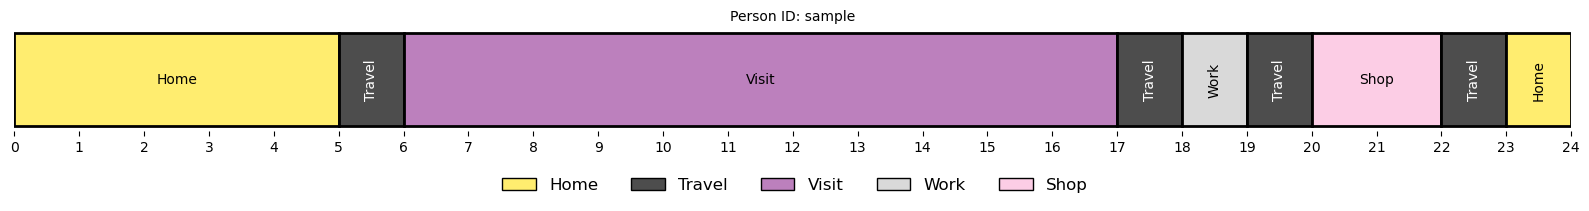

In [2]:
plan = Plan(home_area="h", home_location=Location(loc=Point(0, 0), area="h"))
plan.add(
    Activity(
        seq=1, act="home", area="h", loc=Point(0, 0), start_time=mtdt(0), end_time=mtdt(5 * 60)
    )
)
plan.add(
    Leg(
        seq=1,
        mode="car",
        start_area="h",
        end_area="w",
        start_loc=Point(0, 0),
        end_loc=Point(1, 2),
        start_time=mtdt(5 * 60),
        end_time=mtdt(6 * 60),
    )
)
plan.add(
    Activity(
        seq=2,
        act="visit",
        area="w",
        loc=Point(1, 2),
        start_time=mtdt(6 * 60),
        end_time=mtdt(17 * 60),
    )
)
plan.add(
    Leg(
        seq=2,
        mode="car",
        start_area="w",
        end_area="w",
        start_loc=Point(1, 2),
        end_loc=Point(0, 0),
        start_time=mtdt(17 * 60),
        end_time=mtdt(18 * 60),
    )
)
plan.add(
    Activity(
        seq=3,
        act="work",
        area="w",
        loc=Point(0, 0),
        start_time=mtdt(18 * 60),
        end_time=mtdt(19 * 60),
    )
)
plan.add(
    Leg(
        seq=3,
        mode="car",
        start_area="w",
        end_area="na",
        start_loc=Point(0, 0),
        end_loc=Point(1, 2),
        start_time=mtdt(19 * 60),
        end_time=mtdt(20 * 60),
    )
)
plan.add(
    Activity(
        seq=4,
        act="shop",
        area="na",
        loc=Point(2, 2),
        start_time=mtdt(20 * 60),
        end_time=mtdt(22 * 60),
    )
)
plan.add(
    Leg(
        seq=4,
        mode="car",
        start_area="na",
        end_area="h",
        start_loc=Point(2, 2),
        end_loc=Point(0, 0),
        start_time=mtdt(22 * 60),
        end_time=mtdt(23 * 60),
    )
)
plan.add(
    Activity(
        seq=5, act="home", area="h", loc=Point(0, 0), start_time=mtdt(23 * 60), end_time=END_OF_DAY
    )
)
plan.plot()

The `od` object holds origin-destination data, for example travel time and travel distance between each origin and destination, for each travel mode.

For the discretionary trips location choice, the `od` object needs to include the variable `od_probs`, which provides provides origin-destination probabilities to be considered -amongst others- as part of the location choice.

In [3]:
zone_labels = ("h", "b", "w")
od = ODFactory.from_matrices(
    [
        ODMatrix(
            "time",
            "car",
            zone_labels,
            zone_labels,
            np.array([[20, 30, 40], [30, 10, 30], [40, 30, 20]]),
        ),
        ODMatrix(
            "time",
            "bus",
            zone_labels,
            zone_labels,
            np.array([[30, 40, 45], [40, 10, 40], [45, 40, 30]]),
        ),
        ODMatrix(
            "distance", "car", zone_labels, zone_labels, np.array([[5, 6, 8], [6, 2, 6], [8, 6, 5]])
        ),
        ODMatrix(
            "distance", "bus", zone_labels, zone_labels, np.array([[5, 7, 9], [7, 2, 7], [9, 7, 5]])
        ),
        ODMatrix(
            "od_probs",
            "car",
            zone_labels,
            zone_labels,
            np.array([[500, 333, 250], [333, 1000, 333], [250, 333, 500]]),
        ),
        ODMatrix(
            "od_probs",
            "bus",
            zone_labels,
            zone_labels,
            np.array([[333, 250, 222], [250, 1000, 250], [222, 250, 333]]),
        ),
    ]
)
od

Origin-destination dataset 
--------------------------------------------------
Labels(vars=['time', 'distance', 'od_probs'], origin_zones=('h', 'b', 'w'), destination_zones=('h', 'b', 'w'), mode=['car', 'bus'])
--------------------------------------------------
time - car:
[[20. 30. 40.]
 [30. 10. 30.]
 [40. 30. 20.]]
--------------------------------------------------
time - bus:
[[30. 40. 45.]
 [40. 10. 40.]
 [45. 40. 30.]]
--------------------------------------------------
distance - car:
[[5. 6. 8.]
 [6. 2. 6.]
 [8. 6. 5.]]
--------------------------------------------------
distance - bus:
[[5. 7. 9.]
 [7. 2. 7.]
 [9. 7. 5.]]
--------------------------------------------------
od_probs - car:
[[ 500.  333.  250.]
 [ 333. 1000.  333.]
 [ 250.  333.  500.]]
--------------------------------------------------
od_probs - bus:
[[ 333.  250.  222.]
 [ 250. 1000.  250.]
 [ 222.  250.  333.]]
--------------------------------------------------

## Model application

Initially, the `shop` activity was allocated to zone `na`:

In [4]:
def print_activity_locs(plan):
    summary = PrettyTable(["seq", "purpose", "location"])
    for seq, act in enumerate(plan.activities):
        summary.add_row([seq, act.act, act.location.area])
    print(summary)


print("Work locations and travel modes:")
print_activity_locs(plan)

Work locations and travel modes:
+-----+---------+----------+
| seq | purpose | location |
+-----+---------+----------+
|  0  |   home  |    h     |
|  1  |  visit  |    w     |
|  2  |   work  |    w     |
|  3  |   shop  |    na    |
|  4  |   home  |    h     |
+-----+---------+----------+


We apply the discretionary location choice model:

In [5]:
plan_new = deepcopy(plan)
planner = DiscretionaryTrips(plan=plan_new, od=od)
planner.update_plan()

The location of the shop trip has now been updated:

In [6]:
print_activity_locs(plan_new)

+-----+---------+----------+
| seq | purpose | location |
+-----+---------+----------+
|  0  |   home  |    h     |
|  1  |  visit  |    w     |
|  2  |   work  |    w     |
|  3  |   shop  |    w     |
|  4  |   home  |    h     |
+-----+---------+----------+


<hr>

## Breaking down the calculation

This section goes through some of the calculations behind the model application.

We select the work->shop->home chain:

In [7]:
plan_new = deepcopy(plan)
chains = get_trip_chains_either_anchor(plan_new)
chain = chains[-1]

In [8]:
[act.act for act in chain]

['work', 'travel', 'shop', 'travel', 'home']

In [9]:
model = DiscretionaryTripOD(chain, od)

The durations of the two trips are one hour each:

In [10]:
[x.duration for x in chain if isinstance(x, Leg)]

[datetime.timedelta(seconds=3600), datetime.timedelta(seconds=3600)]

... and therefore, the observed leg ratio is 0.5:

In [11]:
model.observed_leg_ratio

0.5

Of the possible destination zones (h/b/w), zone b has the closest-to-observed leg ratio:

In [12]:
model.leg_ratios

array([0.66666667, 0.5       , 0.33333333])

... and therefore, offers the highest "leg_ratio" probability:

In [13]:
model.leg_ratio_p

array([0.66666667, 1.        , 0.66666667])

The diversion factors are the same each destination:

In [14]:
model.diversion_factors

array([1.5, 1.5, 1.5])

... and therefore the diversion probabilities are equal:

In [15]:
model.diversion_p

array([0.54545455, 0.54545455, 0.54545455])

Attraction probabilities reflect the data in the `od` object:

In [16]:
model.od["od_probs", "w", :, "car"]

array([250., 333., 500.])

.. the more opportunities it offers, the higher the probability of a destination:

In [17]:
model.attraction_p

array([0.23084026, 0.30747922, 0.46168052])

The final probabilities are defined as the product of the three elements:

In [18]:
probs = model.leg_ratio_p * model.diversion_p * model.attraction_p
probs /= probs.sum()
probs

array([0.20008003, 0.3997599 , 0.40016006])

In [19]:
model.destination_p

array([0.20008003, 0.3997599 , 0.40016006])

Running the model multiple times gives us the same probabilities:

In [20]:
res = []
for i in range(10**3):
    planner = DiscretionaryTrips(plan=plan_new, od=od)
    planner.update_plan()
    res.append(list(plan_new.activities)[3].location.area)
res = pd.Series(res)
res.value_counts(normalize=True).loc[list(od.labels.destination_zones)]

h    0.200
b    0.403
w    0.397
Name: proportion, dtype: float64